# Exploring Bike-Sharing Demand in Toronto, 2024

We look at some graphs of bike-sharing usage for the Toronto Bike-Sharing system in May 2024.

We use the ridership data published at Toronto's open data portal, which contains a collection of ride records for each month. Each ride record contains start and end times in minutes, start and end stations along with their id, the precise duration in seconds and several other information about the membership or the type of bike.

However, we do not have any information about historic capacities or bike numbers at time points, so we need to estimate when stations are at their maximum demand or not.
Additionally, the ridership data does not include information about bikes that are added or removed from stations for repair or repositioning purposes.


In [4]:
import analysis as an
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import folium

data = an.BikeShareData.load_from_pickle(name = '2024-5')

avg_lat = np.mean(data.stations['lat'])
avg_lon = np.mean(data.stations['lon'])

## One Station
We first look at a plot of the cumulative number of bikes that should be at a station for one station over one month. We choose the bike station `St. George / Hoskin Ave` right at the University of Toronto here. We group the number of bikes coming in each minute (given by the end minute of each trip) and those that are taken out (given by the start minute of each trip) and then we take the cumulative sum of `inbikes` minus `outbikes`.

Notably, we see, that at this station, it seems that the number of bikes decreases over the course of time. This is explained by the fact that the ridership data only contains rides, but not repairs or repositioning of bikes, or errors of the logging system leading to excluded rides.
We can, however, clearly observe daily patterns over the month.
The larger spikes appear together in groups of 5 for each weekday, where the university is highly frequented, and are much smaller on the two following days. Usually, students use the bike to travel to the university in the morning, taking it back in the evening, thus we notice the peaks during the day.

[Text(0.5, 0, 'time (minutes)'),
 Text(0, 0.5, 'number of bikes'),
 Text(0.5, 1.0, 'Bikes at 7066, Willcocks St / St. George St, Cap: 15')]

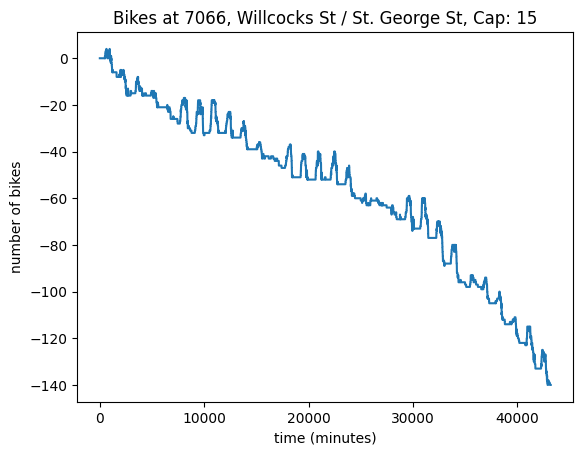

In [7]:
station = 7066 - 7000 # St. George St / Hoskin Ave
N_bikes = np.cumsum(data.in_bikes[station, :] - data.out_bikes[station, :])
plt.plot(N_bikes[0 : 24 * 60 * 30])
plt.gca().set(xlabel='time (minutes)', ylabel='number of bikes', title=f'Bikes at {7000 + station}, {data.stations.loc[station, 'name']}, Cap: {data.stations.loc[station, 'capacity']}', )

Now, we want to analyze demand patterns over the day, week and month. Our main goal here is to analyze the spatial properties of demand patterns over Toronto, thus we use the python library `folium` to visualize the distributions over the map.

## General In / Out Rate Calculation
Given the number of bikes returned and the number of bikes taken out at each minute, there is not a unique way to obtain a sensible continuous input / output rate.
We use a gaussian moving average here with a standard deviation of $60$ minutes because it produces a sensibly localized rate measure, that is smooth but still fine enough to distinguish hourly demand patterns.

In [ ]:
# Out Rates in the morning over toronto | Out Rates at noon | Out Rates in the evening
# (2) In Rates in the morning over toronto | In Rates at noon | In Rates in the evening

# opt: average over all days

In [ ]:
# Out Rates on {Mon, Tu, Wed, Th, Fri, Sat, Sun} ; opt: average over month
# or weekday vs weekend

In [ ]:
# hourly demand pattern
# average over all hours
# beginning of the hour vs end middle of the hour